In [74]:
from pyod.utils.data import generate_data
from pyod.models import knn
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from scipy.linalg import cholesky

(400, 2)
(400,)


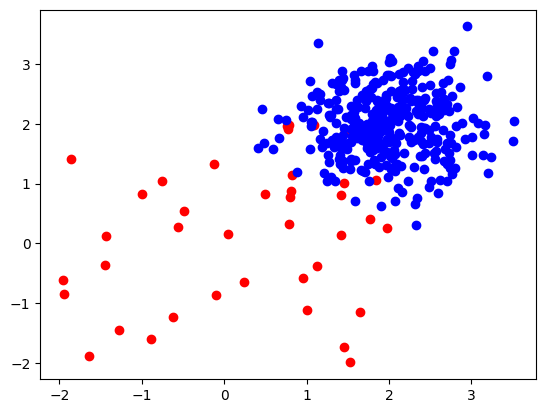

In [62]:
# Ex. 1

X_train, X_test, y_train, y_test = generate_data(n_train=400, n_test=100, n_features=2, contamination=0.1)
print(X_train.shape)
print(y_train.shape)

outliers = y_train == 1
inliers = y_train == 0
plt.scatter(X_train[outliers,0], X_train[outliers,1], color='red')
plt.scatter(X_train[inliers,0], X_train[inliers,1], color='blue')
plt.show()

TN:  89
FN:  1
TP:  9
FP:  1
TPR:  0.9
TNR:  0.9888888888888889
BA:  0.9444444444444444


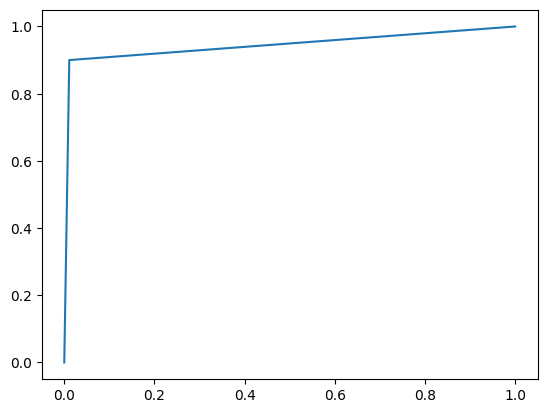

In [63]:
# Ex. 2
model = knn.KNN(contamination=0.1)
y_pred = model.fit(X_train).predict(X_test)

c = confusion_matrix(y_test, y_pred)
TN, FN, TP, FP = c[0,0], c[1,0], c[1,1], c[0,1]
print("TN: ", TN)
print("FN: ", FN)
print("TP: ", TP)
print("FP: ", FP)

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
BA = (TPR+TNR) / 2

print("TPR: ", TPR)
print("TNR: ", TNR)
print("BA: ", BA)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.show()

In [71]:
# Ex 3

contamination = 0.1
X_train, X_test, y_train, y_test = generate_data(n_train=1000, n_test=0, contamination=contamination, n_features=1)

z_scores = (X_train-X_train.mean())/X_train.std()
# If we don't take the absolute value, the outliers will only be considered to be the
# values to the right of the mean (if quantile is < 0.5).
z_scores = np.abs(z_scores)

threshold = np.quantile(z_scores, 1-contamination)
y_pred = z_scores>threshold

confusion_matrix(y_train, y_pred)

array([[876,  24],
       [ 24,  76]])

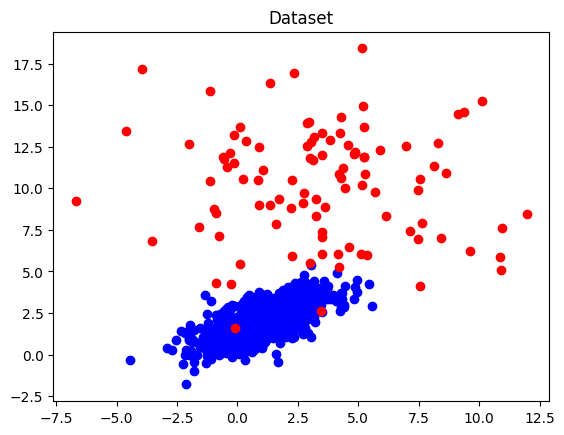

array([[892,   8],
       [ 13,  87]])

In [175]:
# Ex 4

def generate_from_normal(new_mean, new_variance, size=(1000, 2)):
    X = np.random.normal(size=size)
    L = cholesky(new_variance)
    return new_mean + np.dot(X, L.T)

inlier_mean = np.array([1., 2.])
inlier_variance = np.array(
    [
        [1.0, 1.],
        [0., 2.0]
    ]
)

outlier_mean = np.array([3.5, 10.2])
outlier_variance = np.array(
    [
        [15, 0.],
        [10, 10]
    ]
)

dataset_size = 1000
contamination_rate = 0.1
dim = 2
num_inliers = int(dataset_size*(1-contamination_rate))
num_outliers = int(dataset_size*contamination_rate)
inlier_distr = generate_from_normal(inlier_mean, inlier_variance, size=(num_inliers, dim))
outlier_distr = generate_from_normal(outlier_mean, outlier_variance, size=(num_outliers, dim))

x_train = np.concatenate((inlier_distr, outlier_distr))
y_train = np.concatenate((
    np.zeros(shape=(num_inliers,), dtype=np.int32),
    np.ones(shape=(num_outliers,), dtype=np.int32))
)

plt.title("Dataset")
plt.scatter(inlier_distr[:,0], inlier_distr[:,1], color='blue')
plt.scatter(outlier_distr[:,0], outlier_distr[:,1], color='red')
plt.show()

miu = x_train.mean(axis=0)
std = np.cov(x_train, rowvar=False)

# Calculam z = sqrt((x - miu).T * std^-1 * (x - miu)) pentru fiecare
# datapoint pentru ca nu stiu cum se face cu broadcasting
L = cholesky(std)
z_scores = np.zeros_like(y_train)
for i in range(x_train.shape[0]):
    z_x = np.linalg.solve(L, x_train[i]-miu)
    z_scores[i] = np.dot(z_x, z_x)
    
z_scores = np.sqrt(z_scores)

threshold = np.quantile(z_scores, 1-contamination_rate)
y_pred = np.astype(z_scores>threshold, np.bool)

confusion_matrix(y_pred=y_pred, y_true=y_train)